In [6]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

2024-04-05 14:50:18.998402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 14:50:18.998482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 14:50:19.095155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 14:50:19.193215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 14:50:20.580662: W tensorflow/compiler/tf2

In [3]:
# Define the input directory
dataset_path = "../mri_dataset/kaggle_3m/"
output_path = "../mri_dataset/super_resolved/"
X_train = []
y_train = []

In [23]:
# Define the input directory
dataset_path = "../mri_dataset/kaggle_3m/"
output_path = "../mri_dataset/super_resolved/"
X_train = []
y_train = []

# Define the target resolution (width, height)
target_resolution = (64, 64)

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define a custom sorting function to sort filenames by numeric part
def sort_by_numeric(filename):
    return int(''.join(filter(str.isdigit, filename)))

# Function to downsample an image
def downsample_image(img, target_resolution):
    return img.resize(target_resolution, Image.LANCZOS)

# Iterate over TIFF files in the dataset
for patient in os.listdir(dataset_path)[0::10]:
    # Iterate over TIFF files for each patient
    for tif_file in sorted(os.listdir(os.path.join(dataset_path, patient)), key=sort_by_numeric):
        if "_mask" not in tif_file:  # Filter out "mask" images
            # Read original image
            original_image_path = os.path.join(dataset_path, patient, tif_file)
            original_img = Image.open(original_image_path)
            
            # Downsample the image
            downscaled_img = downsample_image(original_img, target_resolution)
            # Save the downsampled image to the output directory
            output_downscaled_image_path = os.path.join(output_path, patient, tif_file)
            os.makedirs(os.path.dirname(output_downscaled_image_path), exist_ok=True)
            downscaled_img.save(output_downscaled_image_path)
            
            # Convert image to numpy array and append to training data
            original_img_array = np.array(original_img)
            downscaled_img_array = np.array(downscaled_img)
            X_train.append(downscaled_img_array)
            y_train.append(original_img_array)

# Convert training data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0


In [59]:
print(y_train.shape)
print(X_train.shape)

(347, 256, 256, 3)
(347, 64, 64, 3)


In [29]:
def build_super_resolution_model(input_shape):
    model = models.Sequential()
    # Upsampling layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(4, 4), activation='relu', padding='same'))  # Upsample by a factor of 4
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model

In [27]:
input_shape = target_resolution + (3,)  # (256, 256, 3)
super_resolution_model = build_super_resolution_model(input_shape)

In [71]:
super_resolution_model = build_super_resolution_model(input_shape)
super_resolution_model.summary()

# Train the super-resolution model
super_resolution_model.compile(optimizer='adam', loss='mse')
super_resolution_model.fit(X_train, y_train, epochs=10, batch_size=16)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 256, 256, 64)      65600     
 Transpose)                                                      
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 3)       1731      
                                                                 
Total params: 69123 (270.01 KB)
Trainable params: 69123 (270.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 27s 1s/step - loss: 0.1470
Epoch 2/10
22/22 [==============================] - 27s 1s/step - loss: 0.0508
Epoch 3/10
22/22 [==============================] - 29s 

In [72]:
super_resolution_model.save('super_resolution_model.keras')

In [73]:
super_resolution_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 256, 256, 64)      65600     
 Transpose)                                                      
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 3)       1731      
                                                                 
Total params: 69123 (270.01 KB)
Trainable params: 69123 (270.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
predicted = super_resolution_model.predict(X_train[1][np.newaxis, ...])

1/1 [==============================] - 0s 72ms/step


In [75]:
X_train[1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [76]:
predicted[0].shape

(256, 256, 3)

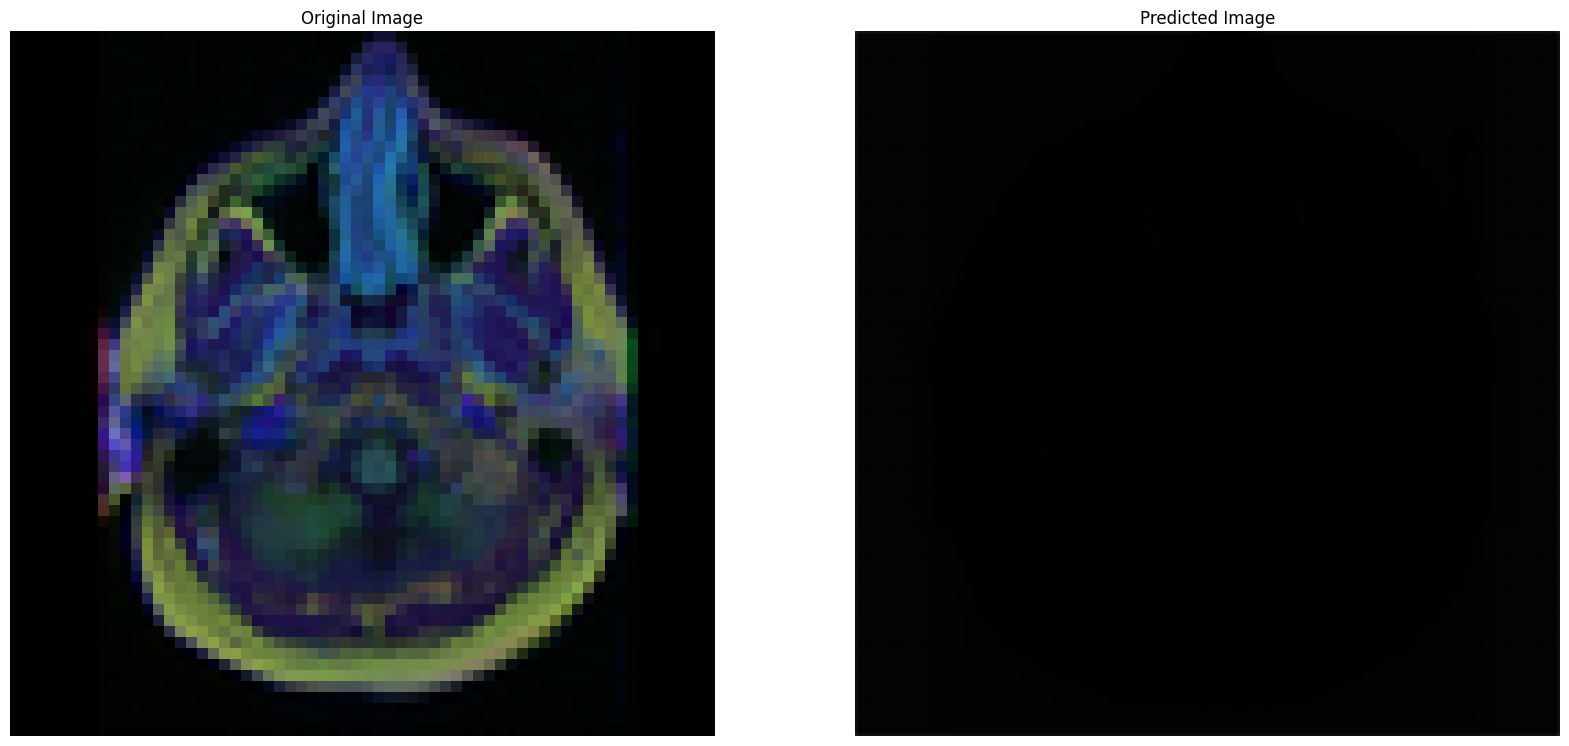

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
# Display original image (X_train[0])
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(X_train[1])
plt.axis('off')

# Display predicted image
plt.subplot(1, 2, 2)
plt.title('Predicted Image')
plt.imshow(predicted[0])
plt.axis('off')

plt.show()
